# Segment 1 Lab 2

## Making our own Customer Support Chatbot

One of the most common business use cases of Gen AI.

We'll even make our own User Interface - no frontend skills required!

We will use the delightful `gradio` framework which makes it remarkably easy for data scientists to build great UIs.

We are going to move quickly as this is just a teaser - but please come back and look at this later!

In [14]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [15]:
# Load environment variables in a file called .env

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [16]:
# Initialize

openai = OpenAI()
MODEL = 'gpt-4o-mini'

In [17]:
system_message = {"role": "system", "content": "You are a helpful assistant"}

Reminder of the structure of prompt messages to OpenAI:

```
[
    {"role": "system", "content": "system message here"},
    {"role": "user", "content": "first user prompt here"},
    {"role": "assistant", "content": "the assistant's response"},
    {"role": "user", "content": "the new user prompt"},
]
```



## The chat function

In order to use Gradio's out-of-the-box Chat User Interfacem we need to write a single function, `chat(message, history)`

In [18]:
def chat(message, history):
    messages = [system_message] + history + [{"role": "user", "content": message}]
    results = openai.chat.completions.create(model=MODEL, messages=messages)
    return results.choices[0].message.content

## And then enter Gradio's magic!

In [19]:
gr.ChatInterface(fn=chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


# Project - Airline AI Assistant

We'll now extend this to make an AI Customer Support assistant for an Airline

In [20]:
system_message["content"] =  """You are a helpful assistant for an Airline called FlightAI.
Give short, courteous answers, no more than 1 sentence.
For context, a return flight to London costs $600.
Always be accurate. If you don't know the answer, say so."""

In [21]:
gr.ChatInterface(fn=chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4c - don't go crazy with images!

In [22]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [23]:
def artist(city):
    prompt = f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style"
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

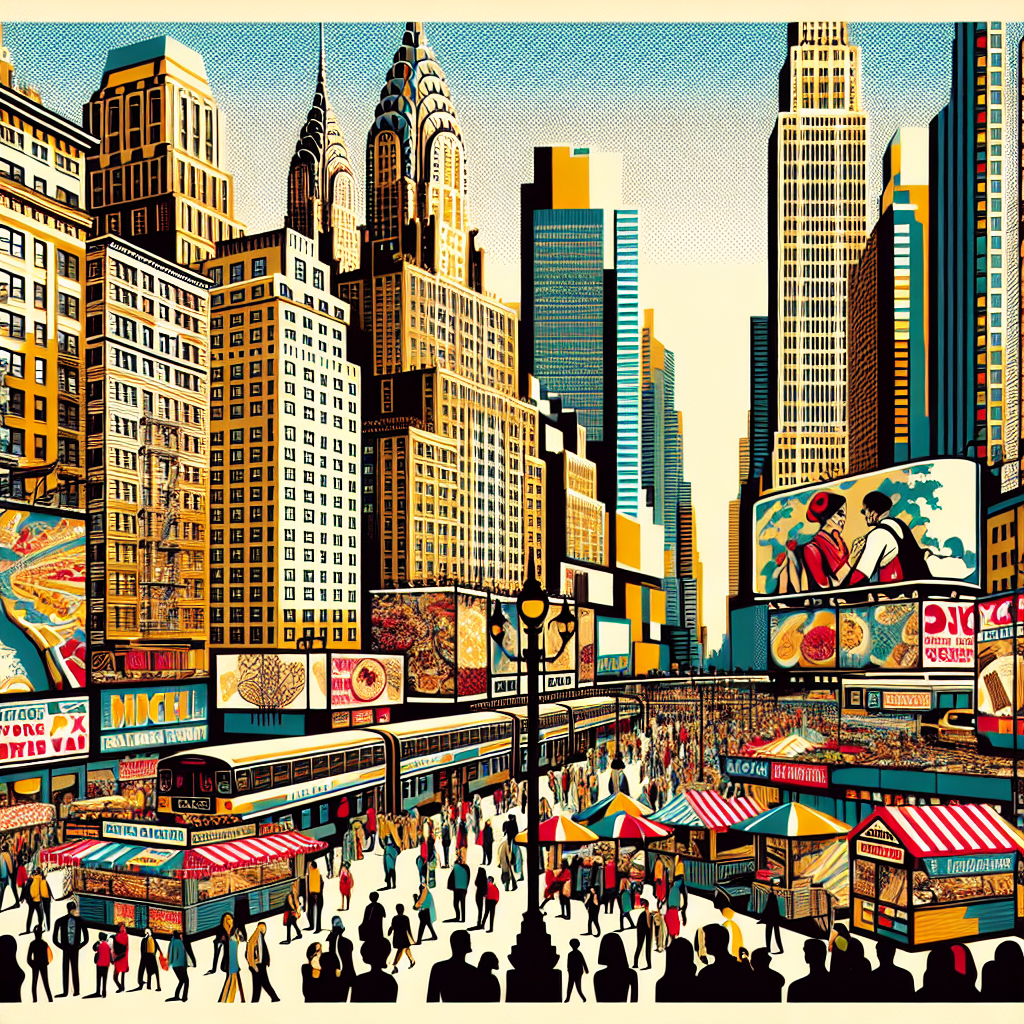

In [24]:
image = artist("New York City")
display(image)

# Bringing it together

This is the start of what you might call an "agent framework", in that we will use multiple LLM calls to solve a complex problem.

We'll work on a full agent framework in the final project today!

In [25]:
def chat(history):
    message = history[-1]["content"]
    messages = [system_message] + history
    results = openai.chat.completions.create(model=MODEL, messages=messages)
    image = artist("London") if "london" in message.lower() else None
    response = results.choices[0].message.content
    history += [{"role":"assistant", "content":response}]
    return history, image

In [26]:
# More involved Gradio code as we're not using the preset Chat interface

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


# A multi-modal customer support chatbot - in minutes!

This illustrated how easy it is to build a chatbot with character and knowledge.

# Exercise

Take this further - have it generate audio for its responses, and use Tools to look up costs of flights.  
See my companion repo llm_engineering in week2 folder for the solution.